## Exercise 1

Find an optimal learning rate for the handwriting MNIST data.  After this, verify that your learning rate achieves better performance than values that are either larger or smaller.

In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import math
import numpy as np
import matplotlib.pyplot as plt

mnist = mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train, y_train = X_train_full[:-5000], y_train_full [: -5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

noise_factor = 0.5
X_train = X_train + noise_factor * np. random.normal (loc=0.0, scale=1.0, size=X_train.shape)
X_valid = X_valid + noise_factor * np. random.normal (loc=0.0, scale=1.0, size=X_valid.shape)
X_test = X_test + noise_factor * np. random.normal (loc=0.0, scale=1.0, size=X_test.shape)

In [21]:
def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [29]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(self.model.optimizer.learning_rate.numpy())
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate.assign(self.model.optimizer.learning_rate * self.factor)

In [33]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = model.optimizer.learning_rate.numpy()
    model.optimizer.learning_rate.assign(min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate.assign(init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

2024-04-09 15:30:53.757242: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1632 - loss: 2.3107


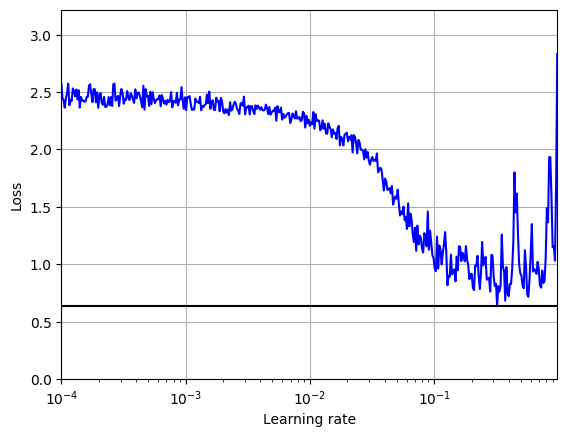

In [35]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [36]:
optimal_lr = 10**-.4
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,metrics=["accuracy"])
history_optimal_lr = model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

Epoch 1/10


2024-04-09 15:31:37.992452: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1151 - loss: 2.4237 - val_accuracy: 0.1246 - val_loss: 2.3440
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1373 - loss: 2.3265 - val_accuracy: 0.1568 - val_loss: 2.2775
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1641 - loss: 2.2664 - val_accuracy: 0.1886 - val_loss: 2.2210
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1930 - loss: 2.2128 - val_accuracy: 0.2248 - val_loss: 2.1658
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2261 - loss: 2.1591 - val_accuracy: 0.2600 - val_loss: 2.1081
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2638 - loss: 2.1024 - val_accuracy: 0.2992 - val_loss: 2.0456
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2992 - loss: 2.0410 - val_accuracy: 0.3396 - val_loss: 1.9770
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3345 - loss: 1.9742 - val_accurac

In [37]:
optimal_lr = 10**-.5
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,metrics=["accuracy"])
history_optimal_lr = model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

Epoch 1/10


2024-04-09 15:32:12.875395: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4271 - loss: 1.7641 - val_accuracy: 0.4502 - val_loss: 1.7307
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4306 - loss: 1.7560 - val_accuracy: 0.4528 - val_loss: 1.7222
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4333 - loss: 1.7480 - val_accuracy: 0.4560 - val_loss: 1.7136
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4360 - loss: 1.7399 - val_accuracy: 0.4596 - val_loss: 1.7051
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4393 - loss: 1.7319 - val_accuracy: 0.4608 - val_loss: 1.6965
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4421 - loss: 1.7238 - val_accuracy: 0.4644 - val_loss: 1.6880
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4456 - loss: 1.7157 - val_accuracy: 0.4664 - val_loss: 1.6794
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4484 - loss: 1.7076 - val_accurac

## Exercise 2

Compare a one cycle learning rate schedule to a power law schedule for the handwriting data.  Which can you make perform more effectively?

In [38]:
class PowerScheduling(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_rate, step_param):
        super(PowerScheduling, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.step_param = step_param

    def __call__(self, step):
        # Note the "cast" here - necessary to make sure we get the correct type back
        return self.initial_learning_rate / (1 + tf.cast(step, tf.float32) / self.step_param) ** self.decay_rate


# Example usage
initial_learning_rate = 0.1
decay_rate = 1.0  # For linear decay
step_param = 1000.0  # Determines how quickly the learning rate decreases

lr_schedule = PowerScheduling(initial_learning_rate, decay_rate, step_param)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10


2024-04-09 15:33:13.386744: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7252 - loss: 0.8195 - val_accuracy: 0.9024 - val_loss: 0.3079
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9088 - loss: 0.2870 - val_accuracy: 0.9074 - val_loss: 0.2825
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9375 - loss: 0.2055 - val_accuracy: 0.9100 - val_loss: 0.2763
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9531 - loss: 0.1618 - val_accuracy: 0.9118 - val_loss: 0.2768
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9630 - loss: 0.1339 - val_accuracy: 0.9118 - val_loss: 0.2801
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9698 - loss: 0.1140 - val_accuracy: 0.9122 - val_loss: 0.2852
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9754 - loss: 0.0991 - val_accuracy: 0.9112 - val_loss: 0.2912
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9790 - loss: 0.0875 - val_accurac

In [39]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr


model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
optimal_lr = 10 ** -.9
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-04-09 15:34:32.211935: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3008 - loss: 1.9684 - val_accuracy: 0.7526 - val_loss: 0.7498
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7437 - loss: 0.7630 - val_accuracy: 0.8290 - val_loss: 0.5214
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8165 - loss: 0.5667 - val_accuracy: 0.8616 - val_loss: 0.4369
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8509 - loss: 0.4672 - val_accuracy: 0.8808 - val_loss: 0.3850
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8727 - loss: 0.3955 - val_accuracy: 0.8916 - val_loss: 0.3496
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8916 - loss: 0.3373 - val_accuracy: 0.8964 - val_loss: 0.3266
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9091 - loss: 0.2869 - val_accuracy: 0.8992 - val_loss: 0.3136
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9251 - loss: 0.2414 - val_accuracy: 0.9034 - val_

## Exercise 3

Re-run all of the code in the second notebook with the handwriting data, instead of the fashion data; graph your losses (training and validation).  Do you achieve similar results?

In [40]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer)

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1740 - loss: 2.3024 - val_accuracy: 0.4118 - val_loss: 1.7676
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4743 - loss: 1.5978 - val_accuracy: 0.6422 - val_loss: 1.0913
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6475 - loss: 1.0598 - val_accuracy: 0.7280 - val_loss: 0.8130
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7156 - loss: 0.8492 - val_accuracy: 0.7696 - val_loss: 0.6956
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7522 - loss: 0.7490 - val_accuracy: 0.7934 - val_loss: 0.6295
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7736 - loss: 0.6869 - val_accuracy: 0.8062 - val_loss: 0.5860
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7887 - loss: 0.6426 - val_accuracy: 0.8182 - val_loss: 0.5542
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8011 - loss: 0.6084 - 

In [41]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=.9)
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5025 - loss: 1.4503 - val_accuracy: 0.8392 - val_loss: 0.5030
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8240 - loss: 0.5484 - val_accuracy: 0.8706 - val_loss: 0.4142
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8614 - loss: 0.4375 - val_accuracy: 0.8854 - val_loss: 0.3725
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8841 - loss: 0.3715 - val_accuracy: 0.8916 - val_loss: 0.3480
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9006 - loss: 0.3231 - val_accuracy: 0.8930 - val_loss: 0.3333
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9137 - loss: 0.2840 - val_accuracy: 0.8960 - val_loss: 0.3252
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9255 - loss: 0.2508 - val_accuracy: 0.8962 - val_loss: 0.3217
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9339 - loss: 0.2216 - 

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

history_nesterov = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5007 - loss: 1.4494 - val_accuracy: 0.8386 - val_loss: 0.5107
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8183 - loss: 0.5579 - val_accuracy: 0.8704 - val_loss: 0.4185
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8568 - loss: 0.4433 - val_accuracy: 0.8814 - val_loss: 0.3735
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8805 - loss: 0.3726 - val_accuracy: 0.8914 - val_loss: 0.3454
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8982 - loss: 0.3203 - val_accuracy: 0.8976 - val_loss: 0.3259
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9130 - loss: 0.2787 - val_accuracy: 0.9026 - val_loss: 0.3134
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9256 - loss: 0.2437 - val_accuracy: 0.9072 - val_loss: 0.3063
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9352 - loss: 0.2133 - 

In [43]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2589 - loss: 2.1060 - val_accuracy: 0.6174 - val_loss: 1.1872
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6398 - loss: 1.1133 - val_accuracy: 0.7408 - val_loss: 0.8084
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7212 - loss: 0.8464 - val_accuracy: 0.7784 - val_loss: 0.6862
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7580 - loss: 0.7435 - val_accuracy: 0.8010 - val_loss: 0.6232
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7766 - loss: 0.6843 - val_accuracy: 0.8156 - val_loss: 0.5835
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7901 - loss: 0.6442 - val_accuracy: 0.8240 - val_loss: 0.5555
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8008 - loss: 0.6142 - val_accuracy: 0.8288 - val_loss: 0.5346
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8096 - loss: 0.5906 - 

In [44]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7331 - loss: 0.7987 - val_accuracy: 0.9076 - val_loss: 0.2968
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9068 - loss: 0.2972 - val_accuracy: 0.9136 - val_loss: 0.3039
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9469 - loss: 0.1716 - val_accuracy: 0.9082 - val_loss: 0.3783
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9666 - loss: 0.1018 - val_accuracy: 0.9104 - val_loss: 0.4299
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9786 - loss: 0.0678 - val_accuracy: 0.9098 - val_loss: 0.5137
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9827 - loss: 0.0531 - val_accuracy: 0.9072 - val_loss: 0.5838
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9860 - loss: 0.0425 - val_accuracy: 0.9106 - val_loss: 0.6516
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9883 - loss: 0.0383 - 

In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7294 - loss: 0.8090 - val_accuracy: 0.9026 - val_loss: 0.2964
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9076 - loss: 0.2842 - val_accuracy: 0.9118 - val_loss: 0.2766
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9452 - loss: 0.1684 - val_accuracy: 0.9048 - val_loss: 0.3427
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9653 - loss: 0.1058 - val_accuracy: 0.9108 - val_loss: 0.3714
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9717 - loss: 0.0842 - val_accuracy: 0.9162 - val_loss: 0.3647
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9779 - loss: 0.0618 - val_accuracy: 0.9204 - val_loss: 0.4264
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9824 - loss: 0.0496 - val_accuracy: 0.9152 - val_loss: 0.4619
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9846 - loss: 0.0458 - 

In [46]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6574 - loss: 1.0313 - val_accuracy: 0.8872 - val_loss: 0.3775
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8806 - loss: 0.3818 - val_accuracy: 0.9006 - val_loss: 0.3101
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9166 - loss: 0.2747 - val_accuracy: 0.9068 - val_loss: 0.2911
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9372 - loss: 0.2073 - val_accuracy: 0.9072 - val_loss: 0.2902
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9556 - loss: 0.1560 - val_accuracy: 0.9078 - val_loss: 0.2996
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9707 - loss: 0.1143 - val_accuracy: 0.9092 - val_loss: 0.3183
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9826 - loss: 0.0805 - val_accuracy: 0.9098 - val_loss: 0.3398
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9909 - loss: 0.0537 - 

In [47]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7252 - loss: 0.8201 - val_accuracy: 0.9018 - val_loss: 0.2999
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9050 - loss: 0.2967 - val_accuracy: 0.9118 - val_loss: 0.2674
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9446 - loss: 0.1768 - val_accuracy: 0.9092 - val_loss: 0.3081
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9646 - loss: 0.1090 - val_accuracy: 0.9092 - val_loss: 0.3520
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9726 - loss: 0.0808 - val_accuracy: 0.9158 - val_loss: 0.3934
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9776 - loss: 0.0636 - val_accuracy: 0.9156 - val_loss: 0.4251
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9818 - loss: 0.0529 - val_accuracy: 0.9036 - val_loss: 0.4897
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9841 - loss: 0.0449 - 

In [48]:
optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer) 

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7320 - loss: 0.8067 - val_accuracy: 0.8982 - val_loss: 0.3155
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9056 - loss: 0.2881 - val_accuracy: 0.9064 - val_loss: 0.2883
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9441 - loss: 0.1730 - val_accuracy: 0.9040 - val_loss: 0.3229
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9653 - loss: 0.1066 - val_accuracy: 0.9092 - val_loss: 0.3587
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9726 - loss: 0.0785 - val_accuracy: 0.9092 - val_loss: 0.4105
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9777 - loss: 0.0642 - val_accuracy: 0.9042 - val_loss: 0.4577
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9815 - loss: 0.0536 - val_accuracy: 0.9116 - val_loss: 0.4724
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9851 - loss: 0.0443 - 

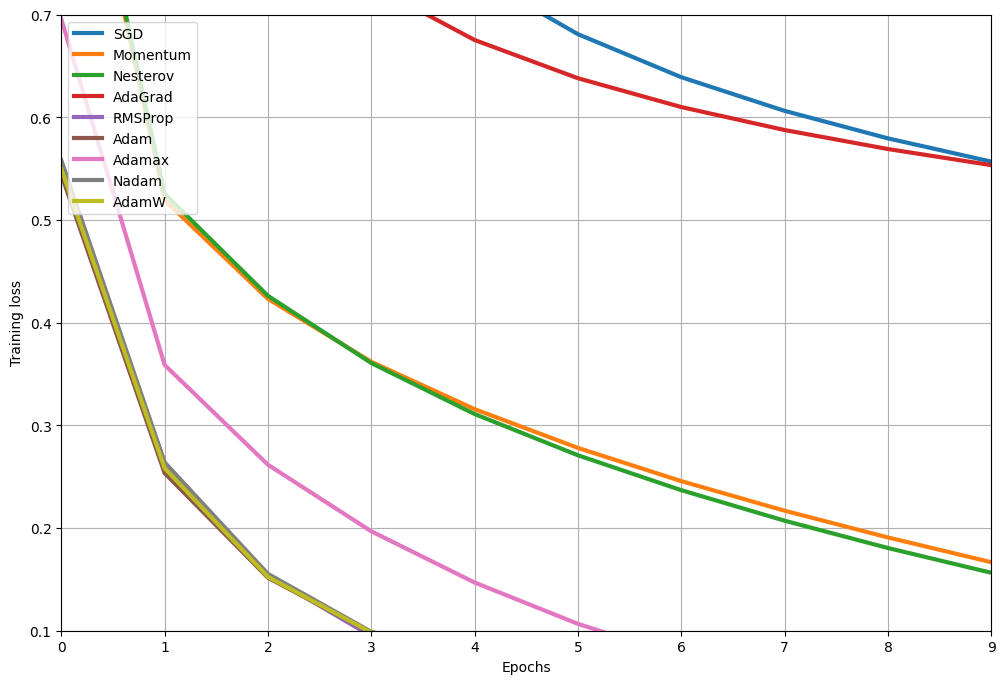

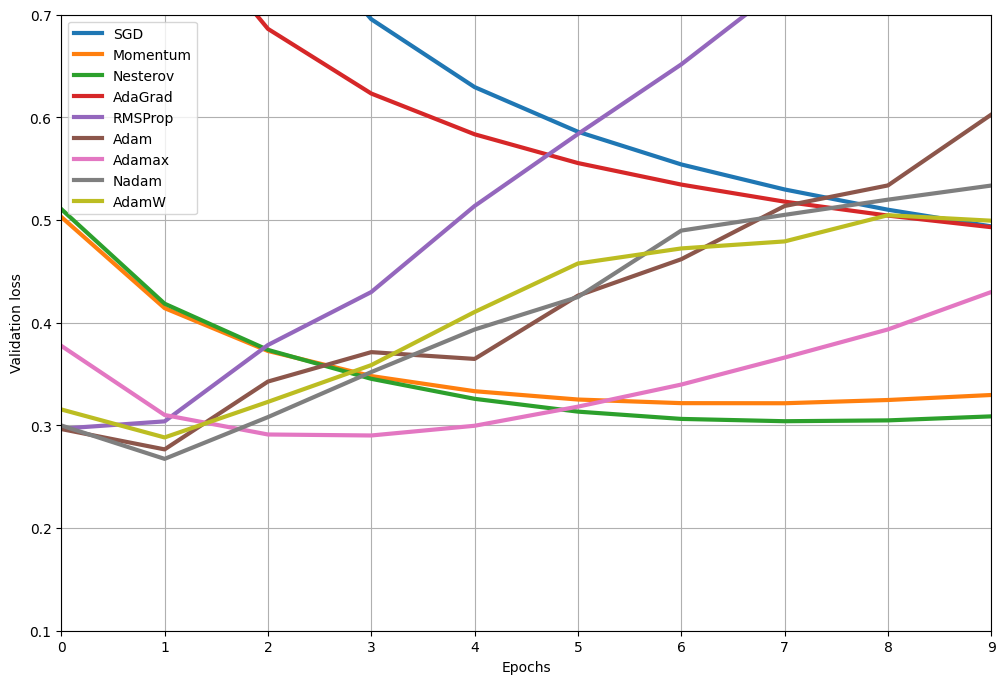

In [49]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Exercise 4

Sometimes, adaptive optimizers fail, and non-adaptive optimizers like NAG or SGD perform a lot better.  This is sometimes the case with noisy data.

In the following, I've create a simple framework to examine the behavior of different optimizers with different noise levels.  Try running with an adaptive optimizer (AdamW) and a non-adaptive optimizer (NAG / SGD) with different levels of noise.  Do you find a point with NAG starts to outperform AdamW?  What happens if you adjust learning rates?

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add noise
noise_factor = 0.5
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

# Define a simple neural network model
def create_model(optimizer):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])


def build_and_train_model(optimizer, n_epochs=10):
    print(f"Optimizer name {optimizer.name}")
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=n_epochs,
                     validation_data=(X_valid, y_valid))

In [6]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

history_nesterov = build_and_train_model(optimizer, n_epochs=20) 

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
